# Properties of the clumps (Using Astrodendro) 

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse

import seaborn as sns
sns.set(style="whitegrid")

import numpy as np

from scipy.ndimage import filters

from astrodendro import Dendrogram, ppv_catalog
from astrodendro.analysis import PPVStatistic

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.wcs import WCS
from astropy.table import Table,Column
from reproject import reproject_interp


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

from astropy.cosmology import WMAP9 as cosmo

redshift=1.033

Some global variables

In [2]:
alma_header = fits.getheader('../Data/Moments/snake_mom0.fits')
mom0 = fits.getdata('../Data/Moments/snake_mom0.fits')[300:700,400:600]
_,_,mom0_rms = sigma_clipped_stats(mom0)

def load_image(file):
    im,_ = reproject_interp(file,alma_header,order=0)
    return im[300:700,400:600]


dendro = Dendrogram.load_from('../FindClumps/snake_dendrograms_min29_delta1.fits')
plotter = dendro.plotter()
cat = Table.read('../FindClumps/snake_small_catalogue.fits')
nb_leaves = len(cat)

# Useful to order results later (idx (-> _idx ->) idx in dendro)
dendro_idx_to_hidden_idx = {}
idx_to_dendro_idx = {}
for i in range(nb_leaves):
    dendro_idx_to_hidden_idx[i] = dendro.leaves[i].idx

idx_to_dendro_idx = {}
for k,v in dendro_idx_to_hidden_idx.items():
    idx_to_dendro_idx[int(np.squeeze(np.where(cat['_idx'] == v)))] = k


cat.show_in_notebook()

idx,_idx,mlt_region,flux,flux_lerr,flux_uerr,radius_corrected,radius_corrected_lerr,radius_corrected_uerr,radius_not_corrected,corrected_area,area_exact_lerr,area_exact_uerr,line_width,line_width_unc
,,,Jy,Jy,Jy,deg,deg,deg,deg2,deg2,deg2,deg2,km / s,km / s
0,0,3,0.005986405054542796,0.0004097367592278958,0.0004604300724045003,4.209456472178027e-05,2.8006596865323617e-06,2.3338830721103055e-06,0.0,5.566752576742246e-09,7.407407407405922e-10,6.172839506171613e-10,49.627359683570134,2.3494275130355717
1,1,1,0.007140259963174313,0.000658083295791697,0.0005621432195988514,4.392200412512356e-05,3.578845509950437e-06,4.4735568874380693e-07,0.0,6.060579737235975e-09,9.876543209874558e-10,1.234567901234326e-10,36.259199484188194,0.18582711555859888
2,3,3,0.001456850150599719,6.796930874593547e-05,0.00019794142374025088,3.257350079352474e-05,3.257350079352474e-05,2.4128519106314635e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,4.938271604937287e-10,48.8886208110508,0.5687467006607569
3,4,2,0.06500840849641121,0.0027008381090581277,0.0014673171748110642,0.00010109855831746266,2.1378775925937116e-06,9.717625420880516e-07,0.0,3.210996245328015e-08,1.3580246913577535e-09,6.172839506171613e-10,39.27365343443875,0.022188945448252895
4,6,3,0.011487549643034995,0.0,0.0,3.0768563925656755e-05,0.0,0.0,0.0,2.9741599841501727e-09,0.0,0.0,56.61044442502862,0.0
5,7,3,0.0013996191732020369,0.00010302176037016659,0.0002955122792543338,3.257350079352474e-05,3.257350079352474e-05,1.8096389329735955e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,3.703703703702961e-10,43.19783121601076,0.061343224006904506
6,8,1,0.0576191601128558,0.0029439435253122356,0.002412255199738929,9.467522355854044e-05,2.4904625731466263e-06,2.2829240253844094e-06,0.0,2.8159345169330322e-08,1.4814814814811845e-09,1.3580246913577535e-09,64.27569363080086,0.2892217359544489
7,9,2,0.0013329259696615362,0.0001707974457464856,3.353456904083094e-05,3.196459662083898e-05,3.196459662083898e-05,0.0,1.0,3.2098765432092345e-09,4.938271604937283e-10,0.0,40.606686447467496,0.08605487184481575
8,10,3,0.004805573479581584,0.0005460102586601068,0.0007621682839024386,3.8689401151045326e-05,5.0785894384079946e-06,2.0314357753632005e-06,0.0,4.7025550458782215e-09,1.2345679012343201e-09,4.938271604937287e-10,50.85941330935636,0.34509302931192565


How we're measuring quantities in the cubes/images

In [3]:
def measure_mean_in_leaf(leaf,im_map):
    v,x,y = leaf.indices()
    im_leaf = im_map[x,y]
    return np.nanmean(im_leaf),np.min(im_leaf),np.max(im_leaf)

def measure_mean_in_ellipse(leaf,im_map):
    xx,yy = np.mgrid[0:im_map.shape[0],0:im_map.shape[1]]
    points = np.vstack((yy.flatten(),xx.flatten())).T
    ellip = PPVStatistic(leaf).to_mpl_ellipse()
    im_leaf = im_map[ellip.contains_points(points).reshape(im_map.shape)]
    return np.mean(im_leaf),np.min(im_leaf),np.max(im_leaf)

### These properties need to be corrected for the magnification

<IPython.core.display.Javascript object>


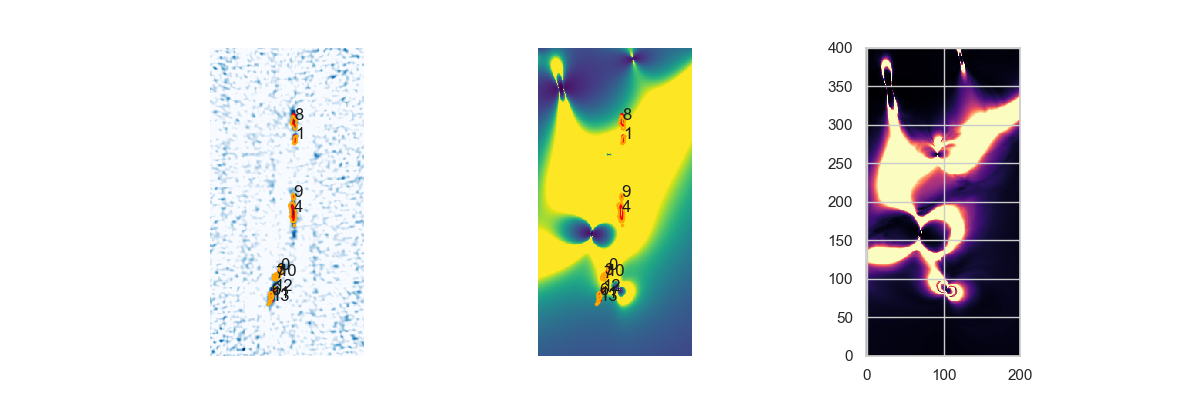

In [4]:
# Data. We have to cut it the same way done for finding the clumps
amp = load_image('../Data/LensigStuff/MACS1206/amp_best_MACS1206.fits')
amp_unc = load_image('../Data/LensigStuff/MACS1206/MACS1206_ampli_mad_uncertainty.fits')
# Plotting
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(mom0, origin='lower', interpolation='nearest',cmap=plt.cm.Blues, vmax=5*mom0_rms,vmin=0)
ax[1].imshow(amp, origin='lower', interpolation='nearest',cmap='viridis',vmin=0,vmax=20)
ax[2].imshow(amp_unc, origin='lower', interpolation='nearest',cmap='magma',vmin=0,vmax=20)

for c in cat:
    for i in range(2):
        leaf = dendro[c['_idx']]
        plotter.plot_contour(ax[i], structure=leaf, lw=3, colors='orange')
        s = PPVStatistic(leaf)
        ellipse = s.to_mpl_ellipse(edgecolor='red', facecolor='none',lw=1.5)
        ax[i].add_patch(ellipse)
        ax[i].annotate('%s'%leaf.idx,xy=ellipse.center,color='k')
        ax[i].axis('off')

In [5]:
amp_in_leaves = []
amp_unc_in_leaves = []
for idx in range(nb_leaves):
    leaf = dendro.leaves[idx_to_dendro_idx[idx]]
    amp_in_leaves.append((measure_mean_in_leaf(leaf,amp)))
    amp_unc_in_leaves.append((measure_mean_in_leaf(leaf,amp_unc)))

# Save it to catalogue
col_amp_leaf = Column(name='mu', data=np.array(amp_in_leaves).T[0])
col_amp_leaf_unc = Column(name='mu_unc', data=np.array(amp_unc_in_leaves).T[0])

cat.add_columns([col_amp_leaf,col_amp_leaf_unc])
cat.show_in_notebook()

idx,_idx,mlt_region,flux,flux_lerr,flux_uerr,radius_corrected,radius_corrected_lerr,radius_corrected_uerr,radius_not_corrected,corrected_area,area_exact_lerr,area_exact_uerr,line_width,line_width_unc,mu,mu_unc
,,,Jy,Jy,Jy,deg,deg,deg,deg2,deg2,deg2,deg2,km / s,km / s,,
0,0,3,0.005986405054542796,0.0004097367592278958,0.0004604300724045003,4.209456472178027e-05,2.8006596865323617e-06,2.3338830721103055e-06,0.0,5.566752576742246e-09,7.407407407405922e-10,6.172839506171613e-10,49.627359683570134,2.3494275130355717,53.2249838739848,21.971937879383994
1,1,1,0.007140259963174313,0.000658083295791697,0.0005621432195988514,4.392200412512356e-05,3.578845509950437e-06,4.4735568874380693e-07,0.0,6.060579737235975e-09,9.876543209874558e-10,1.234567901234326e-10,36.259199484188194,0.18582711555859888,32.21793566680536,14.512273172052895
2,3,3,0.001456850150599719,6.796930874593547e-05,0.00019794142374025088,3.257350079352474e-05,3.257350079352474e-05,2.4128519106314635e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,4.938271604937287e-10,48.8886208110508,0.5687467006607569,40.21556414498223,29.157272338867188
3,4,2,0.06500840849641121,0.0027008381090581277,0.0014673171748110642,0.00010109855831746266,2.1378775925937116e-06,9.717625420880516e-07,0.0,3.210996245328015e-08,1.3580246913577535e-09,6.172839506171613e-10,39.27365343443875,0.022188945448252895,294.1917889615873,108.80865834113253
4,6,3,0.011487549643034995,0.0,0.0,3.0768563925656755e-05,0.0,0.0,0.0,2.9741599841501727e-09,0.0,0.0,56.61044442502862,0.0,12.069487300030021,4.030833024618238
5,7,3,0.0013996191732020369,0.00010302176037016659,0.0002955122792543338,3.257350079352474e-05,3.257350079352474e-05,1.8096389329735955e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,3.703703703702961e-10,43.19783121601076,0.061343224006904506,34.20980504353841,32.06504135131836
6,8,1,0.0576191601128558,0.0029439435253122356,0.002412255199738929,9.467522355854044e-05,2.4904625731466263e-06,2.2829240253844094e-06,0.0,2.8159345169330322e-08,1.4814814814811845e-09,1.3580246913577535e-09,64.27569363080086,0.2892217359544489,16.64246469711367,5.336378946146035
7,9,2,0.0013329259696615362,0.0001707974457464856,3.353456904083094e-05,3.196459662083898e-05,3.196459662083898e-05,0.0,1.0,3.2098765432092345e-09,4.938271604937283e-10,0.0,40.606686447467496,0.08605487184481575,40.65474274579216,3.815602512920604
8,10,3,0.004805573479581584,0.0005460102586601068,0.0007621682839024386,3.8689401151045326e-05,5.0785894384079946e-06,2.0314357753632005e-06,0.0,4.7025550458782215e-09,1.2345679012343201e-09,4.938271604937287e-10,50.85941330935636,0.34509302931192565,54.690685836128566,41.191744265349016


### Calculate intrinsic properties of clumps

In [6]:
def correct_for_magnification(catalog,new_column,param, units, func, func_err):
    
    # remove column if exists
    if new_column in catalog.colnames:
        catalog.remove_column(new_column)
        catalog.remove_column(new_column+'_lerr')
        catalog.remove_column(new_column+'_uerr')
    
    # calculate values
    mu = catalog['mu']
    mu_unc = catalog['mu_unc']
    
    new_values = func(catalog[param],mu)
    new_lerr = func_err(catalog[param],mu,catalog[param+'_lerr'],mu_unc)
    new_uerr = func_err(catalog[param],mu,catalog[param+'_uerr'],mu_unc)

    # add column
    cat.add_column(Column(name=new_column, data=new_values, unit=units))
    cat.add_column(Column(name=new_column+'_lerr', data=new_lerr, unit=units))
    cat.add_column(Column(name=new_column+'_uerr', data=new_uerr, unit=units))

    return catalog

In [7]:
kpc_per_deg = cosmo.kpc_proper_per_arcmin(z=redshift).to('kpc/deg').value

cat = correct_for_magnification(cat,'radius_kpc',param='radius_corrected',units=u.kpc,
                               func = lambda a,mu: a/np.sqrt(mu)*kpc_per_deg, 
                               func_err = lambda a,mu,a_unc,mu_unc: (a_unc/np.sqrt(mu) + mu_unc * a/(2*mu**(3/2)))*kpc_per_deg)

cat = correct_for_magnification(cat,'flux_intrinsic',param='flux',units=u.Jy, 
                               func = lambda a,mu: a/mu, 
                               func_err = lambda a,mu,a_unc,mu_unc : a_unc/mu + mu_unc * a/mu**2)

In [8]:
cat.show_in_notebook()

idx,_idx,mlt_region,flux,flux_lerr,flux_uerr,radius_corrected,radius_corrected_lerr,radius_corrected_uerr,radius_not_corrected,corrected_area,area_exact_lerr,area_exact_uerr,line_width,line_width_unc,mu,mu_unc,radius_kpc,radius_kpc_lerr,radius_kpc_uerr,flux_intrinsic,flux_intrinsic_lerr,flux_intrinsic_uerr
,,,Jy,Jy,Jy,deg,deg,deg,deg2,deg2,deg2,deg2,km / s,km / s,,,kpc,kpc,kpc,Jy,Jy,Jy
0,0,3,0.005986405054542796,0.0004097367592278958,0.0004604300724045003,4.209456472178027e-05,2.8006596865323617e-06,2.3338830721103055e-06,0.0,5.566752576742246e-09,7.407407407405922e-10,6.172839506171613e-10,49.627359683570134,2.3494275130355717,53.2249838739848,21.971937879383994,0.17062692763013687,0.046570711499861174,0.04467867008941221,0.00011247359076174035,5.412870608541943e-05,5.50811406281264e-05
1,1,1,0.007140259963174313,0.000658083295791697,0.0005621432195988514,4.392200412512356e-05,3.578845509950437e-06,4.4735568874380693e-07,0.0,6.060579737235975e-09,9.876543209874558e-10,1.234567901234326e-10,36.259199484188194,0.18582711555859888,32.21793566680536,14.512273172052895,0.22882981547949988,0.0701826175497498,0.05386782836296132,0.00022162375755598252,0.00012025437777668474,0.00011727653099019138
2,3,3,0.001456850150599719,6.796930874593547e-05,0.00019794142374025088,3.257350079352474e-05,3.257350079352474e-05,2.4128519106314635e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,4.938271604937287e-10,48.8886208110508,0.5687467006607569,40.21556414498223,29.157272338867188,0.15189611653950913,0.20696032527710279,0.06631577292570542,3.6226027946483325e-05,2.7954885011285726e-05,3.118677091808911e-05
3,4,2,0.06500840849641121,0.0027008381090581277,0.0014673171748110642,0.00010109855831746266,2.1378775925937116e-06,9.717625420880516e-07,0.0,3.210996245328015e-08,1.3580246913577535e-09,6.172839506171613e-10,39.27365343443875,0.022188945448252895,294.1917889615873,108.80865834113253,0.17430466316014728,0.03591975880121573,0.03390925247484353,0.00022097288549715224,9.090872795659167e-05,8.671581374032126e-05
4,6,3,0.011487549643034995,0.0,0.0,3.0768563925656755e-05,0.0,0.0,0.0,2.9741599841501727e-09,0.0,0.0,56.61044442502862,0.0,12.069487300030021,4.030833024618238,0.261904000780674,0.043733891481196364,0.043733891481196364,0.0009517843929465357,0.00031786635737174806,0.00031786635737174806
5,7,3,0.0013996191732020369,0.00010302176037016659,0.0002955122792543338,3.257350079352474e-05,3.257350079352474e-05,1.8096389329735955e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,3.703703703702961e-10,43.19783121601076,0.061343224006904506,34.20980504353841,32.06504135131836,0.16469046420380398,0.24187311020459193,0.0863321162343326,4.091280764157405e-05,4.1359271922042685e-05,4.6986036489662603e-05
6,8,1,0.0576191601128558,0.0029439435253122356,0.002412255199738929,9.467522355854044e-05,2.4904625731466263e-06,2.2829240253844094e-06,0.0,2.8159345169330322e-08,1.4814814814811845e-09,1.3580246913577535e-09,64.27569363080086,0.2892217359544489,16.64246469711367,5.336378946146035,0.686288677831577,0.128081715231449,0.12657729464294362,0.003462177097052745,0.0012870348763646957,0.0012550871850070856
7,9,2,0.0013329259696615362,0.0001707974457464856,3.353456904083094e-05,3.196459662083898e-05,3.196459662083898e-05,0.0,1.0,3.2098765432092345e-09,4.938271604937283e-10,0.0,40.606686447467496,0.08605487184481575,40.65474274579216,3.815602512920604,0.14824939733434703,0.15520628274061915,0.006956885406272143,3.2786481468991616e-05,7.278305231928217e-06,3.901998620816735e-06
8,10,3,0.004805573479581584,0.0005460102586601068,0.0007621682839024386,3.8689401151045326e-05,5.0785894384079946e-06,2.0314357753632005e-06,0.0,4.7025550458782215e-09,1.2345679012343201e-09,4.938271604937287e-10,50.85941330935636,0.34509302931192565,54.690685836128566,41.191744265349016,0.15470866543983866,0.07856940626564919,0.06638464603223734,8.786822483778456e-05,7.616389594581797e-05,8.01162695892938e-05


## Derived quantities

In [8]:
def radius(sigma_r):
    # Solomon 1987
    return 1.91*sigma_r

def delta_V(sigma_v):
    return np.sqrt(8*np.log(2))*sigma_v

In [11]:
cat = correct_for_magnification(cat,'R',param='radius_kpc',units=u.kpc,func = lambda a,b: 1.91*a*1000, func_err = lambda a,mu,a_unc,mu_unc: 1.91*a_unc*1000)

In [12]:
from astropy.constants import G

def Lline_CO43(flux):
    # Carilli 2013 pg 9 
    line_freq =  461.040768 # GHz, observed frequency
    DL = cosmo.luminosity_distance(redshift).value # Mpc
    delta_v = 29.940078 # km/s
    return 3.25e7 * flux*delta_v  * DL**2 *1/(line_freq)**2 * 1/(1+redshift)**3 # K km/s px**2
    
def L_CO43(flux):
    # Carilli 2013 pg 9 
    line_freq =  461.040768 # GHz, observed frequency
    DL = cosmo.luminosity_distance(redshift).value # Mpc
    delta_v = 29.940078 # km/s
    return 1.04e-3 * flux*delta_v  * DL**2 * line_freq # Lsun

# alpha  = 3.6 +/- 0.8 from Daddi 2010
def molecular_mass(Lline_CO,alpha=4.3):
    r41 = 0.33
    Lline_CO10 = Lline_CO/0.33
    return alpha*Lline_CO10

# for the luminosities and the mass, since it is simple multiplication, and we assume the other factors do not have uncertainties
# we can calculate the uncertainty just using param_unc instead of the param in the function

def virial_parameter(sigma_v,radius,mol_mass):
    return (5*sigma_v**2*radius*u.pc.to(u.km)/(mol_mass*u.Msun.to(u.kg)*G.to(u.km**3/u.kg/u.s**2))).value
    
    
def virial_paramater_unc(sigma_v,radius,mol_mass,sigma_v_unc,radius_unc,mol_mass_unc):
    part1 = sigma_v_unc * 2 *(5*sigma_v*radius*u.pc.to(u.km)/(mol_mass*u.Msun.to(u.kg)*G.to(u.km**3/u.kg/u.s**2)))
    part2 = radius_unc*u.kpc.to(u.m) * (5*sigma_v**2/(mol_mass*u.Msun.to(u.kg)*G.to(u.km**3/u.kg/u.s**2)))
    part3 = mol_mass_unc*u.Msun.to(u.kg) * 1/((mol_mass*u.Msun.to(u.kg))**2) * (5*sigma_v**2*radius*u.pc.to(u.km)/(G.to(u.km**3/u.kg/u.s**2)))
    return part1.value + part2.value + part3.value
    
    
def virial_mass(sigma_v,R):
    # Bias free clouds
    return 1040*(sigma_v)**2*R

def virial_mass_unc(sigma_v,R,sigma_v_unc,R_unc):
    return sigma_v_unc * (1040*2*(sigma_v)*R) + R_unc * (1040*sigma_v**2)


def internal_pressure(mol_mass,R,sigma_v):
    return 1176 * mol_mass * R**(-3) * sigma_v**2

def internal_pressure_unc(mol_mass,R,sigma_v,mol_mass_unc,R_unc,sigma_v_unc):
    part1 = mol_mass_unc * (1176 * R**(-3) * sigma_v**2)
    part2 = R_unc *(1176 * mol_mass * R**(-4)/3 * sigma_v**2)
    part3 = sigma_v_unc * (1176 * mol_mass * R**(-3) * 2*sigma_v)
    return part1+part2+part3

pc2_per_deg2 = cosmo.kpc_proper_per_arcmin(z=redshift).to('pc/deg')**2
pc2_per_deg2 = pc2_per_deg2.value

def gas_density(magnified_molecular_mass,corrected_area):
    return magnified_molecular_mass/(corrected_area*pc2_per_deg2)

def gas_density_unc(magnified_molecular_mass,corrected_area,magnified_molecular_mass_unc,corrected_area_unc):
    return magnified_molecular_mass_unc/(corrected_area*pc2_per_deg2) + corrected_area_unc * (magnified_molecular_mass/(corrected_area*pc2_per_deg2)**2)

In [13]:
L_CO = []
Ll_CO_lerr = []
Ll_CO_uerr = []

Ll_CO = []
L_CO_lerr = []
L_CO_uerr = []

mol_mass = [] 
mol_mass_lerr = [] 
mol_mass_uerr = [] 

vir_mass = []
vir_mass_lerr = []
vir_mass_uerr= []

vir_param = []
vir_param_lerr = []
vir_param_uerr = []

P_int = []
P_int_lerr = []
P_int_uerr = []

gas_den = []
gas_den_lerr = []
gas_den_uerr = []


for clump in cat:
    
    Ll_CO.append(Lline_CO43(clump['flux_intrinsic']))
    Ll_CO_lerr.append(Lline_CO43(clump['flux_intrinsic_lerr']))
    Ll_CO_uerr.append(Lline_CO43(clump['flux_intrinsic_uerr']))

    L_CO.append(L_CO43(clump['flux_intrinsic']))
    L_CO_lerr.append(L_CO43(clump['flux_intrinsic_lerr']))
    L_CO_uerr.append(L_CO43(clump['flux_intrinsic_uerr']))

    mol_mass.append(molecular_mass(Ll_CO[-1]))
    mol_mass_lerr.append(molecular_mass(Ll_CO_lerr[-1]))
    mol_mass_uerr.append(molecular_mass(Ll_CO_uerr[-1]))
    
    vir_mass.append(virial_mass(clump['line_width'],clump['R']))
    vir_mass_lerr.append(virial_mass_unc(clump['line_width'],clump['R'],clump['line_width_unc'],clump['R_lerr']))
    vir_mass_uerr.append(virial_mass_unc(clump['line_width'],clump['R'],clump['line_width_unc'],clump['R_uerr']))

    vir_param.append(virial_parameter(clump['line_width'],clump['R'],mol_mass[-1]))
    vir_param_lerr.append(virial_paramater_unc(clump['line_width'],clump['R'],mol_mass[-1],clump['line_width_unc'],clump['R_lerr'],mol_mass_uerr[-1]))
    vir_param_uerr.append(virial_paramater_unc(clump['line_width'],clump['R'],mol_mass[-1],clump['line_width_unc'],clump['R_uerr'],mol_mass_lerr[-1]))
    
    P_int.append(internal_pressure(mol_mass[-1],clump['R'],clump['line_width']))
    P_int_lerr.append(internal_pressure_unc(mol_mass[-1],clump['R'],clump['line_width'],mol_mass_lerr[-1],clump['R_lerr'],clump['line_width_unc'] )) # this is not correct, but no-one knows how to deal with asymetric errors anyways
    P_int_uerr.append(internal_pressure_unc(mol_mass[-1],clump['R'],clump['line_width'],mol_mass_uerr[-1],clump['R_uerr'],clump['line_width_unc'] ))
    
    mol_mass_obs = molecular_mass(Lline_CO43(clump['flux']))
    mol_mass_obs_lerr = molecular_mass(Lline_CO43(clump['flux_lerr']))
    mol_mass_obs_uerr = molecular_mass(Lline_CO43(clump['flux_uerr']))
    
    gas_den.append(gas_density(mol_mass_obs,clump['corrected_area']))
    gas_den_lerr.append(gas_density_unc(mol_mass_obs,clump['corrected_area'],mol_mass_obs_lerr,clump['area_exact_lerr']))
    gas_den_uerr.append(gas_density_unc(mol_mass_obs,clump['corrected_area'],mol_mass_obs_uerr,clump['area_exact_uerr']))

Save it to catalogue

In [14]:
cat.add_column(Column(name='Ll_CO43', data=Ll_CO, unit=u.K*u.km/u.s*u.pc**2))
cat.add_column(Column(name='Ll_CO43_lerr', data=Ll_CO_lerr, unit=u.K*u.km/u.s*u.pc**2))
cat.add_column(Column(name='Ll_CO43_uerr', data=Ll_CO_uerr, unit=u.K*u.km/u.s*u.pc**2))

cat.add_column(Column(name='L_CO43', data=L_CO, unit=u.L_sun))
cat.add_column(Column(name='L_CO43_lerr', data=L_CO_lerr, unit=u.L_sun))
cat.add_column(Column(name='L_CO43_uerr', data=L_CO_uerr, unit=u.L_sun))

cat.add_column(Column(name='Mass_mol', data=mol_mass, unit=u.M_sun))
cat.add_column(Column(name='Mass_mol_lerr', data=mol_mass_lerr, unit=u.M_sun))
cat.add_column(Column(name='Mass_mol_uerr', data=mol_mass_uerr, unit=u.M_sun))

cat.add_column(Column(name='Mass_vir', data=vir_mass, unit=u.M_sun))
cat.add_column(Column(name='Mass_vir_lerr', data=vir_mass_lerr, unit=u.M_sun))
cat.add_column(Column(name='Mass_vir_uerr', data=vir_mass_uerr, unit=u.M_sun))

cat.add_column(Column(name='vir_param', data=vir_param))
cat.add_column(Column(name='vir_param_lerr', data=vir_param_lerr))
cat.add_column(Column(name='vir_param_uerr', data=vir_param_uerr))

cat.add_column(Column(name='P_int', data=P_int))
cat.add_column(Column(name='P_int_lerr', data=P_int_lerr))
cat.add_column(Column(name='P_int_uerr', data=P_int_uerr))

cat.add_column(Column(name='gas_density', data=gas_den))
cat.add_column(Column(name='gas_density_lerr', data=gas_den_lerr))
cat.add_column(Column(name='gas_density_uerr', data=gas_den_uerr))

# MUSE

Metallicity

<IPython.core.display.Javascript object>


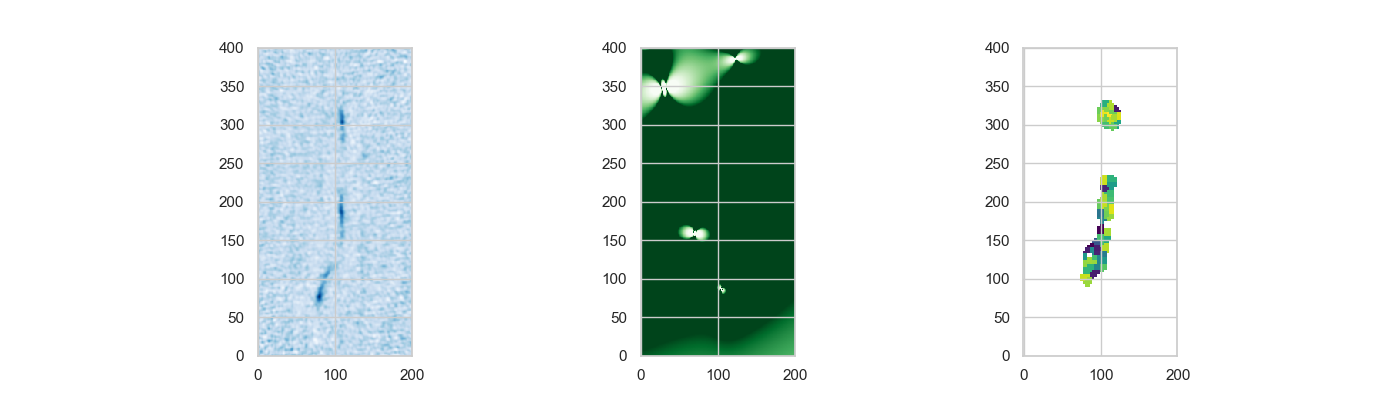

In [15]:
met_map = load_image('../Data/MUSE/M1206_Map_metallicity.fits')
met_map_unc = load_image('../Data/MUSE/M1206_Map_metallicity_unc.fits')

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].imshow(mom0,origin='lower',cmap='Blues')
ax[1].imshow(amp,origin='lower',cmap='Greens',vmin=2,vmax=6)
ax[2].imshow(met_map,origin='lower',cmap='viridis')

met_in_leaves = []
met_unc_in_leaves = []
for idx in range(nb_leaves):
    leaf = dendro.leaves[idx_to_dendro_idx[idx]]
    met_in_leaves.append((measure_mean_in_leaf(leaf,met_map)))
    met_unc_in_leaves.append((measure_mean_in_leaf(leaf,met_map_unc)))
    
    
# Save it to catalogue
col_met_leaf = Column(name='met', data=np.array(met_in_leaves).T[0])
col_met_unc_leaf = Column(name='met_unc', data=np.array(met_in_leaves).T[0])

cat.add_columns([col_met_leaf,col_met_unc_leaf])

In [14]:
cat.show_in_notebook()

idx,_idx,mlt_region,flux,flux_lerr,flux_uerr,radius_corrected,radius_corrected_lerr,radius_corrected_uerr,radius_not_corrected,corrected_area,area_exact_lerr,area_exact_uerr,line_width,line_width_unc,mu,mu_unc,radius_kpc,radius_kpc_lerr,radius_kpc_uerr,flux_intrinsic,flux_intrinsic_lerr,flux_intrinsic_uerr,R,R_lerr,R_uerr,Ll_CO43,Ll_CO43_lerr,Ll_CO43_uerr,L_CO43,L_CO43_lerr,L_CO43_uerr,Mass_mol,Mass_mol_lerr,Mass_mol_uerr,Mass_vir,Mass_vir_lerr,Mass_vir_uerr,vir_param,vir_param_lerr,vir_param_uerr,P_int,P_int_lerr,P_int_uerr,gas_density,gas_density_lerr,gas_density_uerr,met,met_unc
,,,Jy,Jy,Jy,deg,deg,deg,deg2,deg2,deg2,deg2,km / s,km / s,,,kpc,kpc,kpc,Jy,Jy,Jy,kpc,kpc,kpc,K km pc2 / s,K km pc2 / s,K km pc2 / s,solLum,solLum,solLum,solMass,solMass,solMass,solMass,solMass,solMass,,,,,,,,,,,
0,0,3,0.005986405054542796,0.0004097367592278958,0.0004604300724045003,4.209456472178027e-05,2.8006596865323617e-06,2.3338830721103055e-06,0.0,5.566752576742246e-09,7.407407407405922e-10,6.172839506171613e-10,49.627359683570134,2.3494275130355717,53.2249838739848,21.971937879383994,0.17062692763013687,0.046570711499861174,0.04467867008941221,0.00011247359076174035,5.412870608541943e-05,5.50811406281264e-05,325.8974317735614,88.95005896473484,85.33625987077733,3005034.5262320926,1446193.9869202205,1471640.8377358355,79182.56582260442,38107.16634432462,38777.69006779474,39156510.49332727,18844345.890172567,19175926.067466944,834750364.8679402,306872238.12445927,297615889.90525496,23830.228787781893,20430.76728254298,19964.723434747142,3276504.960131123,2185164.6777541055,2200799.5652506123,428.1135440217151,29.30203594825477,32.9273325602456,8.820041969804532,8.820041969804532
1,1,1,0.007140259963174313,0.000658083295791697,0.0005621432195988514,4.392200412512356e-05,3.578845509950437e-06,4.4735568874380693e-07,0.0,6.060579737235975e-09,9.876543209874558e-10,1.234567901234326e-10,36.259199484188194,0.18582711555859888,32.21793566680536,14.512273172052895,0.22882981547949988,0.0701826175497498,0.05386782836296132,0.00022162375755598252,0.00012025437777668474,0.00011727653099019138,437.06494756584476,134.04879952002213,102.88755217325611,5921274.841307581,3212919.181312562,3133357.994133982,156025.40695712354,84660.31998506933,82563.88519016147,77156005.50794727,41865310.54437581,40828604.165988244,597607088.6501685,189412864.60693407,146805507.4868503,8658.079736679527,7325.7888235306045,6824.83138003194,1428813.5087541959,936001.4377544853,882846.6724980993,469.0235418420511,43.22763594199648,36.92560288260622,nan,nan
2,3,3,0.001456850150599719,6.796930874593547e-05,0.00019794142374025088,3.257350079352474e-05,3.257350079352474e-05,2.4128519106314635e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,4.938271604937287e-10,48.8886208110508,0.5687467006607569,40.21556414498223,29.157272338867188,0.15189611653950913,0.20696032527710279,0.06631577292570542,3.6226027946483325e-05,2.7954885011285726e-05,3.118677091808911e-05,290.1215825904624,395.29422127926625,126.66312628809736,967875.7830185826,746889.9504926038,833238.4761243714,25503.496624735468,19680.526846151333,21955.807797114427,12611714.748423954,9732202.385206655,10857349.840408474,721155547.0167633,999362447.8970065,331625830.2888923,63919.06084326606,143605.2504587638,78718.42968591269,1451633.2885628222,1813260.3303137585,1494732.0601172165,173.99265911360166,8.117623327251888,23.640286306124874,8.786101157696667,8.786101157696667
3,4,2,0.06500840849641121,0.0027008381090581277,0.0014673171748110642,0.00010109855831746266,2.1378775925937116e-06,9.717625420880516e-07,0.0,3.210996245328015e-08,1.3580246913577535e-09,6.172839506171613e-10,39.27365343443875,0.022188945448252895,294.1917889615873,108.80865834113253,0.17430466316014728,0.03591975880121573,0.03390925247484353,0.00022097288549715224,9.090872795659167e-05,8.671581374032126e-05,332.92190663588127,68.60673931032204,64.76667222695114,5903885.043438606,2428871.2078562565,2316846.2258130237,155567.18632691717,64000.68039546136,6

Distance

<IPython.core.display.Javascript object>


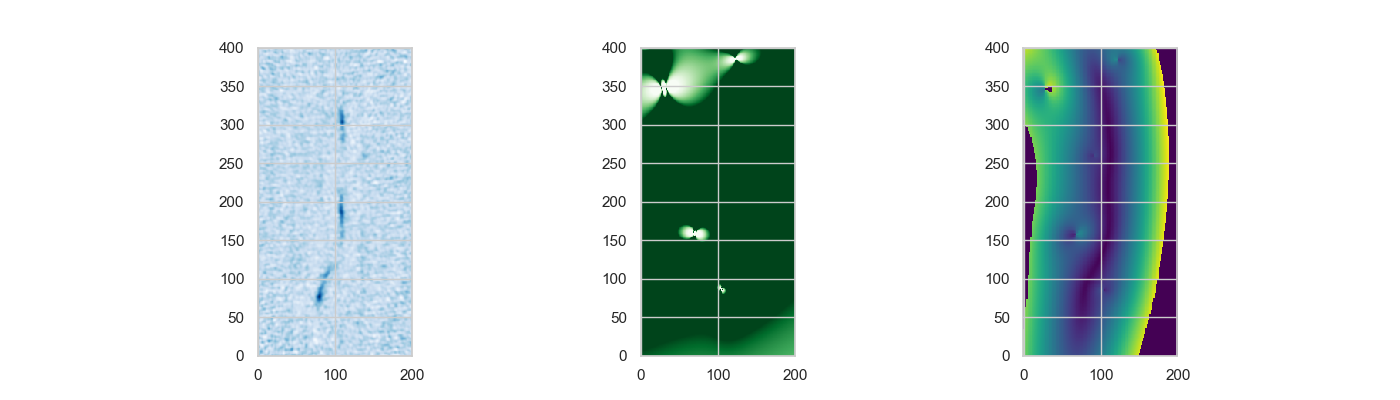

In [16]:
dist_map = load_image('M1206_deprojected_galactic_centre_distance.fits')

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].imshow(mom0,origin='lower',cmap='Blues')
ax[1].imshow(amp,origin='lower',cmap='Greens',vmin=2,vmax=6)
ax[2].imshow(dist_map,origin='lower',cmap='viridis')

dist_in_leaves = []
for idx in range(nb_leaves):
    leaf = dendro.leaves[idx_to_dendro_idx[idx]]
    dist_in_leaves.append((measure_mean_in_leaf(leaf,dist_map)))    
    
# Save it to catalogue
cat.add_column(Column(name='Galactic_R', data=np.array(dist_in_leaves).T[0]))

## HST

Measure photometry

In [16]:
filters = ['F105W','F110w','F125w','F140w','F160w','F225w','F275w','F336w','F435w','F475w','F606w','F625w','F775w','F814w','F850w']
           
# From Arcs
ZeroPoint = {'F435w' : 25.6585, 'F475w' : 26.06, 'F606w' : 26.5059, 'F625w' : 25.9074, 'F775w' : 25.6658, 
              'F814w' : 25.9441, 'F850w': 24.8432, 'F105W' : 24.8432, 'F110w' : 26.8259, 'F125w': 26.2481,
              'F140w' : 26.4652, 'F160w' : 25.9566, 'F225w' : 24.0973, 'F275w' : 24.1749, 'F336w' : 24.646,
              'F390w': 25.3721}

def measure_phot_in_leaf(leaf,im_map):
    
    v,x,y = leaf.indices()
    im_select = im_map[x,y]
    
    flux = np.nansum(im_select)
    flux_std = np.nanstd(im_select)
                
    ## Photometry in AB magnitures
    mag =  -2.5* np.log10(flux) + ZeroPoint[filt] ## in mag AB
    mag_err = 2.5/np.log(10) * (flux_std/ flux)
    
    mJy_zp = 23.93 #microJansky (DC: why not 23.90?, I don't know!)
    flux = 10.**(-0.4 * (mag - mJy_zp ))
    flux_err = np.sqrt(flux**2. * (-0.4 * np.log(10.) * mag_err)**2.)
    
    return flux, flux_err


nb_clumps = len(cat)
all_phot = np.arange(nb_clumps)

for filt in filters:
    
    print(filt)    
    try:
        im_map,_ = reproject_interp('../Data/HST/MACS1206_arc_'+filt+'.fits',alma_header)
    except ValueError:
        im_map,_ = reproject_interp('../Data/HST/MACS1206_arc_'+filt+'.fits',alma_header,hdu_in=1) 

    im_map = im_map[300:700,400:600]
    
    phot = []
    for idx in range(nb_leaves):
        leaf = dendro.leaves[idx_to_dendro_idx[idx]]
        phot.append(measure_phot_in_leaf(leaf,im_map))
    phot = np.array(phot)
    all_phot = np.dstack((all_phot,phot.T[0]))
    all_phot = np.dstack((all_phot,phot.T[1]))
        
all_phot = np.squeeze(all_phot)

F105W
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
F110w
INFO: 
 

F475w
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
F606w
INFO: 
 

In [17]:
all_phot[np.where(np.isnan(all_phot))] = -99

In [18]:
t = Table(all_phot,names= ['id',
                           'F_F105W','E_F105W','F_F110w','E_F110w','F_F125w','E_F125w','F_F140w','E_F140w','F_F160w','E_F160w','F_F225w','E_F225w','F_F275w','E_F275w',
                            'F_F336w','E_F336w','F_F435w','E_F435w','F_F475w','E_F475w','F_F606w','E_F606w','F_F625w','E_F625w','F_F775w','E_F775w','F_F814w','E_F814w','F_F850w','E_F850w'])

t.add_column(Column(data=np.ones((nb_clumps,))*redshift,name='z_spec'))
t.write('FAST/MACS1206/snake_clump_photometry.cat',format='ascii.commented_header')
t.show_in_notebook()

idx,id,F_F105W,E_F105W,F_F110w,E_F110w,F_F125w,E_F125w,F_F140w,E_F140w,F_F160w,E_F160w,F_F225w,E_F225w,F_F275w,E_F275w,F_F336w,E_F336w,F_F435w,E_F435w,F_F475w,E_F475w,F_F606w,E_F606w,F_F625w,E_F625w,F_F775w,E_F775w,F_F814w,E_F814w,F_F850w,E_F850w,z_spec
0,0.0,3.3416505988754945,0.0018409983787161027,1.2233832440974564,0.0007543392157940783,1.5745661513240983,0.0009091184176188118,1.952564767966686,0.0012194646888103423,2.356340275248396,0.0010630226089060506,-99.0,-99.0,0.036484102248697095,0.0007877166762123948,0.022591822931646223,0.0007921190254834134,0.031043839700705317,0.0005489310394618135,0.044595080575314444,0.0004097267580795816,0.07132017460430534,0.00020246010387779591,0.11085754054390029,0.0004956070258389855,0.23279410595442834,0.0008845031914151583,0.33460228426233574,0.0005303748291776576,0.5145999719863596,0.0007237395280516903,1.033
1,1.0,3.650996533807881,0.0014698616218634304,1.308607423201844,0.00040158233242606334,1.5890090883409542,0.0005485091169325097,2.0342362619562073,0.0007273473501616882,2.486502383873326,0.000816648696178679,-99.0,-99.0,-99.0,-99.0,0.006698007625246581,0.0007966409142650569,-99.0,-99.0,0.04554239994875363,0.000410795890402131,0.08900914842520745,0.00022823409836025924,0.09785272522536001,0.0004848019250799702,0.292993212765512,0.0005488539329910824,0.3495444417699355,0.00043167071556041755,0.6446977164946469,0.0009777603477149788,1.033
2,2.0,0.8379429233301867,0.00149390971374769,0.29770068261016636,0.00027700004773679467,0.3813282056048978,0.000297314311821861,0.46754739792958927,0.00022844706065597203,0.5770592271321437,0.0003799491583575466,-99.0,-99.0,0.007458595049054848,0.0007014844391105871,-99.0,-99.0,0.015567440847041213,0.0005525973453275183,0.014663318265258497,0.0004694232704272148,0.022412447966367363,0.00032978762209503836,0.034158621169713604,0.00031947779950572554,0.07281120508938821,0.0008714576158343845,0.09148044585007016,0.0005677267726083918,0.14205178697686532,0.0009655066014327512,1.033
3,3.0,35.04194729828196,0.0031722096717433463,12.610808091547229,0.000841829291960104,15.896374080526044,0.0011268281189706884,19.764956716119812,0.0013306903360784104,24.155710397174815,0.0016487527634026769,-99.0,-99.0,0.25997135973665714,0.0008720049310611656,0.12487401081953436,0.0007333844482847142,0.18288746578491719,0.0005797085778227741,0.31469101684321166,0.0004781691678566556,0.8704844740599215,0.0003964049201946576,1.1214510464407084,0.0006295274215786827,2.848561776024351,0.0008835305250877291,3.870332624241501,0.000780805567599883,5.990143834322574,0.0010970946759538691,1.033
4,4.0,5.4166021411567815,0.00450067553439245,2.0108012478025454,0.0015962808895458795,2.5355858215347364,0.0020947279854603585,3.336923811810123,0.0030079567442619225,4.109558774623717,0.003293599167291653,0.011572011657887599,0.0009747931525043425,-99.0,-99.0,0.03141492750094703,0.000460405511598344,0.01498631703791673,0.0004699680442588489,0.054873347462877115,0.0005746617711076375,0.1228928356280571,0.0003933903727255907,0.2043697601610419,0.0006565893977539379,0.3718929841970878,0.0008630762019736144,0.5701363072590097,0.0009042599270639984,0.8608588875589421,0.0013223737157703503,1.033
5,5.0,0.7280254552643776,0.0018034362050541144,0.2650581945951082,0.00037702344940790855,0.3217191974871728,0.0004404930955747629,0.4015777574137923,0.00034798854064554117,0.49899308020236366,0.0005337120904040824,0.0028869383576470126,0.001456191306856745,-99.0,-99.0,0.006936121465373526,0.0009039991138127382,0.007645861951310954,0.0003627153253696966,0.0082958530391358,0.0006031910270721783,0.01736321305083199,0.0002219864899610143,0.021401117319990406,0.00031722251155269965,0.054733403723640064,0.0006803719733043588,0.07410280237557441,0.000645135265302203,0.13409174786364175,0.0008182866010464078,1.033
6,6.0,34.87076572680714,0.005304324511395136,12.736784026275911,0.0019391595477107155,15.966186489951975,0.0024648562680833243,20.347815814754675,0.0033283272310372864,24.536036119577698,0.0041297104128

Fit with FAST (see input files in FAST directory)

Read results and correct for amplification

In [17]:
fast = Table.read('FAST/MACS1206/fast.out',format='ascii')
fast.show_in_notebook()

idx,id,z,l68_z,u68_z,ltau,l68_ltau,u68_ltau,metal,l68_metal,u68_metal,lage,l68_lage,u68_lage,Av,l68_Av,u68_Av,lmass,l68_lmass,u68_lmass,lsfr,l68_lsfr,u68_lsfr,lssfr,l68_lssfr,u68_lssfr,la2t,l68_la2t,u68_la2t,chi2
0,0,1.03,1.03,1.03,9.5,8.5,10.0,0.004,0.004,0.05,9.6,8.66,9.6,2.1,1.09,3.0,10.2,9.96,10.24,0.55,-0.34,1.32,-9.65,-10.47,-8.64,0.1,-1.2,0.6,3.55
1,1,1.03,1.03,1.03,9.0,8.5,10.0,0.004,0.004,0.05,9.4,8.61,9.6,1.8,0.99,2.78,10.1,9.95,10.2,0.29,-0.38,1.13,-9.81,-10.46,-8.88,0.4,-0.6,0.6,0.91
2,2,1.03,1.03,1.03,9.5,8.81,10.0,0.008,0.004,0.05,9.6,9.19,9.6,1.7,0.66,2.06,9.5,9.4,9.62,-0.15,-1.0,0.13,-9.66,-10.47,-9.36,0.1,-0.4,0.6,3.7
3,3,1.03,1.03,1.03,8.5,8.5,8.54,0.004,0.004,0.0057,9.4,9.36,9.42,0.7,0.63,0.8,10.88,10.88,10.93,-0.81,-0.81,-0.76,-11.69,-11.69,-11.69,0.9,0.9,0.9,4.09
4,4,1.03,1.03,1.03,8.5,8.5,8.5,0.004,0.004,0.0042,9.6,9.58,9.6,0.6,0.59,0.7,10.23,10.23,10.28,-3.46,-3.46,-3.41,-13.68,-13.68,-13.68,1.1,1.1,1.1,12.4
5,5,1.03,1.03,1.03,8.5,8.5,9.31,0.05,0.004,0.05,9.0,8.76,9.6,1.8,0.7,2.56,9.35,9.18,9.46,-0.29,-1.26,0.22,-9.65,-10.46,-9.12,0.5,0.2,0.7,0.318
6,6,1.03,1.03,1.03,8.5,8.5,8.51,0.004,0.004,0.0045,9.4,9.39,9.41,0.8,0.7,0.81,10.93,10.88,10.93,-0.76,-0.81,-0.76,-11.69,-11.69,-11.69,0.9,0.9,0.9,5.22
7,7,1.03,1.03,1.03,8.5,8.5,8.73,0.02,0.004,0.0416,9.0,8.94,9.14,2.3,2.18,2.44,9.52,9.45,9.52,-0.13,-0.2,-0.13,-9.65,-9.65,-9.64,0.5,0.5,0.5,17.1
8,8,1.03,1.03,1.03,9.0,8.5,9.24,0.004,0.004,0.026,9.6,8.6,9.6,1.3,1.07,3.0,10.02,9.74,10.02,-0.43,-0.7,1.12,-10.45,-10.45,-8.74,0.6,0.1,0.7,4.11
9,9,1.03,1.03,1.03,8.5,8.5,8.51,0.004,0.004,0.008,9.6,9.4,9.6,0.7,0.54,0.76,9.72,9.6,9.72,-3.96,-4.01,-2.1,-13.68,-13.68,-11.7,1.1,0.9,1.1,2.23


In [18]:
stellar_mass = 10**fast['lmass']
stellar_mass_lerr = (fast['lmass']-fast['l68_lmass'])*10**fast['lmass']
stellar_mass_uerr = (fast['u68_lmass']-fast['lmass'])*10**fast['lmass']

cat.add_column(stellar_mass/cat['mu'],name='Mass_stellar')
cat.add_column(stellar_mass_lerr/cat['mu'] + cat['mu_unc']*stellar_mass/cat['mu'],name='Mass_stellar_lerr')
cat.add_column(stellar_mass_uerr/cat['mu'] + cat['mu_unc']*stellar_mass/cat['mu'],name='Mass_stellar_uerr')

cat.show_in_notebook()

idx,_idx,mlt_region,flux,flux_lerr,flux_uerr,radius_corrected,radius_corrected_lerr,radius_corrected_uerr,radius_not_corrected,corrected_area,area_exact_lerr,area_exact_uerr,line_width,line_width_unc,mu,mu_unc,radius_kpc,radius_kpc_lerr,radius_kpc_uerr,flux_intrinsic,flux_intrinsic_lerr,flux_intrinsic_uerr,R,R_lerr,R_uerr,Ll_CO43,Ll_CO43_lerr,Ll_CO43_uerr,L_CO43,L_CO43_lerr,L_CO43_uerr,Mass_mol,Mass_mol_lerr,Mass_mol_uerr,Mass_vir,Mass_vir_lerr,Mass_vir_uerr,vir_param,vir_param_lerr,vir_param_uerr,P_int,P_int_lerr,P_int_uerr,gas_density,gas_density_lerr,gas_density_uerr,met,met_unc,Galactic_R,Mass_stellar,Mass_stellar_lerr,Mass_stellar_uerr
,,,Jy,Jy,Jy,deg,deg,deg,deg2,deg2,deg2,deg2,km / s,km / s,,,kpc,kpc,kpc,Jy,Jy,Jy,kpc,kpc,kpc,K km pc2 / s,K km pc2 / s,K km pc2 / s,solLum,solLum,solLum,solMass,solMass,solMass,solMass,solMass,solMass,,,,,,,,,,,,,,,
0,0,3,0.005986405054542796,0.0004097367592278958,0.0004604300724045003,4.209456472178027e-05,2.8006596865323617e-06,2.3338830721103055e-06,0.0,5.566752576742246e-09,7.407407407405922e-10,6.172839506171613e-10,49.627359683570134,2.3494275130355717,53.2249838739848,21.971937879383994,0.17062692763013687,0.046570711499861174,0.04467867008941221,0.00011247359076174035,5.412870608541943e-05,5.50811406281264e-05,325.8974317735614,88.95005896473484,85.33625987077733,3005034.5262320926,1446193.9869202205,1471640.8377358355,79182.56582260442,38107.16634432462,38777.69006779474,39156510.49332727,18844345.890172567,19175926.067466944,834750364.8679402,306872238.12445927,297615889.90525496,23.83022878778189,6504208.342223008,6239960.4023167,3276504.960131123,2185164.6777541055,2200799.5652506123,428.1135440217151,29.30203594825477,32.9273325602456,8.820041969804532,8.820041969804532,0.8536537263890822,297772413.8373618,6614102358.349703,6554547875.582231
1,1,1,0.007140259963174313,0.000658083295791697,0.0005621432195988514,4.392200412512356e-05,3.578845509950437e-06,4.4735568874380693e-07,0.0,6.060579737235975e-09,9.876543209874558e-10,1.234567901234326e-10,36.259199484188194,0.18582711555859888,32.21793566680536,14.512273172052895,0.22882981547949988,0.0701826175497498,0.05386782836296132,0.00022162375755598252,0.00012025437777668474,0.00011727653099019138,437.06494756584476,134.04879952002213,102.88755217325611,5921274.841307581,3212919.181312562,3133357.994133982,156025.40695712354,84660.31998506933,82563.88519016147,77156005.50794727,41865310.54437581,40828604.165988244,597607088.6501685,189412864.60693407,146805507.4868503,8.658079736679525,2655457.14099158,2038165.5579450524,1428813.5087541959,936001.4377544853,882846.6724980993,469.0235418420511,43.22763594199648,36.92560288260622,nan,nan,0.7386799352924999,390752972.1375838,5729326820.272827,5709789171.665948
2,3,3,0.001456850150599719,6.796930874593547e-05,0.00019794142374025088,3.257350079352474e-05,3.257350079352474e-05,2.4128519106314635e-06,1.0,3.3333333333326667e-09,1.2345679012343218e-10,4.938271604937287e-10,48.8886208110508,0.5687467006607569,40.21556414498223,29.157272338867188,0.15189611653950913,0.20696032527710279,0.06631577292570542,3.6226027946483325e-05,2.7954885011285726e-05,3.118677091808911e-05,290.1215825904624,395.29422127926625,126.66312628809736,967875.7830185826,746889.9504926038,833238.4761243714,25503.496624735468,19680.526846151333,21955.807797114427,12611714.748423954,9732202.385206655,10857349.840408474,721155547.0167633,999362447.8970065,331625830.2888923,63.91906084326605,87090562.34797569,27906241.049853798,1451633.2885628222,1813260.3303137585,1494732.0601172165,173.99265911360166,8.117623327251888,23.640286306124874,8.786101157696667,8.786101157696667,0.9308593687083986,78633179.15342343,2300592337.3626432,2302165000.9457116
3,4,2,0.06500840849641121,0.0027008381090581277,0.0014673171748110642,0.00010109855831746266,2.1378775925937116e-06,9.717625420880516e-07,0.0,3.210996245328015e-08,1.3580246913577535e-09,6.172839506171613e-10,39.27365343443875,0.022188945448252895,294.1917889615873,108.808658341

## Save final catalogue

In [19]:
cat.write('snake_clump_properties.fits',overwrite=True)

## Some preliminary plots

are the clumps virialised?

<IPython.core.display.Javascript object>


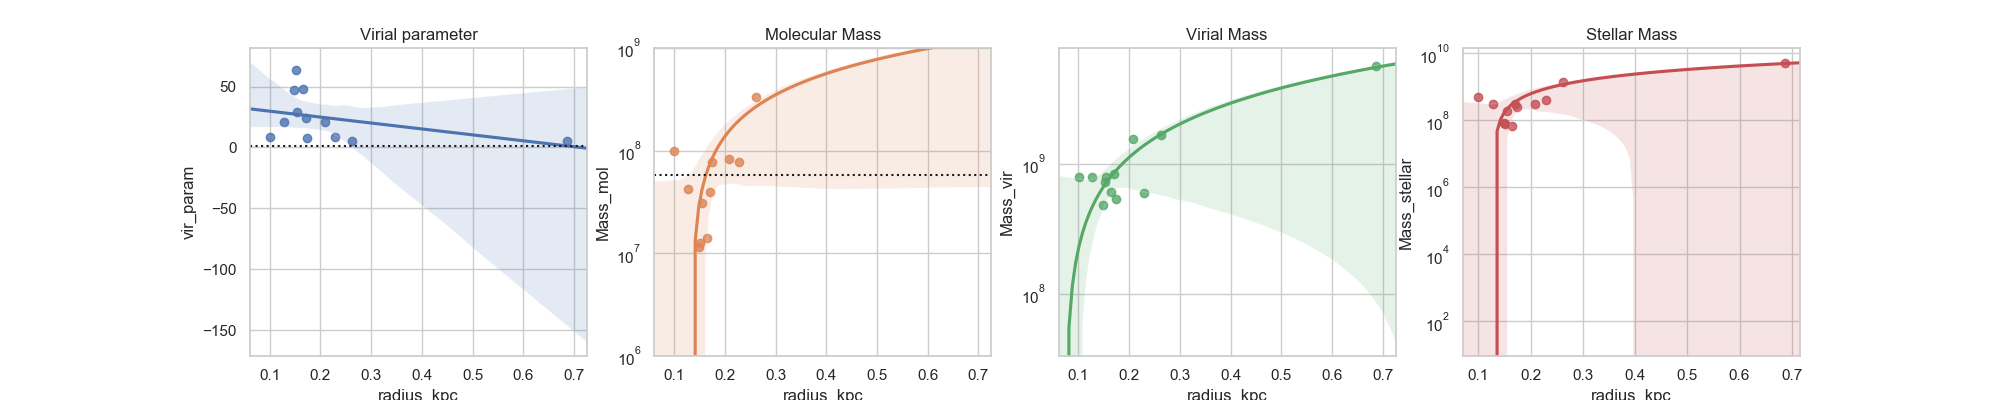

In [20]:
fig, ax = plt.subplots(1,4,figsize=(20,4))

# Virialised
ax[0].set_title('Virial parameter')
sns.regplot(cat['radius_kpc'],cat['vir_param'],ax=ax[0])
ax[0].axhline(1,linestyle=':',color='k')

ax[1].set_title('Molecular Mass')
sns.regplot(cat['radius_kpc'],cat['Mass_mol'],ax=ax[1])
ax[1].axhline(2.9E5,linestyle=':',color='k')
ax[1].axhline(5.8E7,linestyle=':',color='k')
ax[1].set_yscale('log')
ax[1].set_ylim(1e6,1e9)

ax[2].set_title('Virial Mass')
sns.regplot(cat['radius_kpc'],cat['Mass_vir'],ax=ax[2])
ax[2].set_yscale('log')

ax[3].set_title('Stellar Mass')
sns.regplot(cat['radius_kpc'],cat['Mass_stellar'],ax=ax[3])
ax[3].set_yscale('log')

### Noise properties

In [20]:
cat_noise = Table.read('../FindClumps/snake_noise_small_catalogue.fits')

In [21]:
cat_noise.show_in_notebook()

idx,_idx,flux,radius_corrected,radius_not_corrected,corrected_area,line_width,line_width_not_corrected
,,Jy,deg,deg2,deg,km / s,
0,0,0.0009219211722603123,3.0710591064115636e-05,1.0,2.9629629629623706e-09,2.7416621531492398,1.0
1,1,0.0014309550109091775,1.5470915403321218e-05,0.0,7.519377619283951e-10,4.053131777032555,0.0
2,2,0.0010841197666007852,1.102073831366594e-05,0.0,3.81567391558099e-10,5.0588626007735495,0.0
3,3,0.0008950180393892508,3.196459662083898e-05,1.0,3.2098765432092345e-09,3.024696296864116,1.0
4,4,0.0010585197284549313,1.8878883812044888e-06,0.0,1.1197021187802495e-11,2.733591780864355,0.0
5,5,0.0008503400667895244,3.0710591064115636e-05,1.0,2.9629629629623706e-09,2.5966877585843813,1.0
6,6,0.0013105611972228527,1.5470915403321218e-05,0.0,7.519377619283951e-10,5.548396285653327,0.0
7,7,0.0011842344839400293,1.2678887561261442e-05,0.0,5.050241816815308e-10,2.6627642357215158,1.0
8,8,0.0011331704981462547,1.8878883812044888e-06,0.0,1.1197021187802495e-11,2.7427752843541464,1.0


Radius

In [22]:
cat_noise.add_column(Column(name='R', data=cat_noise['radius_corrected']*kpc_per_deg*1.91*1000, unit=u.pc))

CO luminosity, masses and virial parameter

In [23]:
L_CO = []
Ll_CO = []
mol_mass = [] 
vir_mass = []
vir_param = []
gas_den = []

for clump in cat_noise:  
    Ll_CO.append(Lline_CO43(clump['flux']))
    L_CO.append(L_CO43(clump['flux'])) 
    mol_mass.append(molecular_mass(Ll_CO[-1]))
    vir_mass.append(virial_mass(clump['line_width'],clump['R']))
    vir_param.append(virial_parameter(clump['line_width'],clump['R'],mol_mass[-1]))
    gas_den.append(gas_density(mol_mass[-1],clump['corrected_area']))
    
cat_noise.add_column(Column(name='Ll_CO43', data=Ll_CO, unit=u.K*u.km/u.s*u.pc**2))
cat_noise.add_column(Column(name='L_CO43', data=L_CO, unit=u.L_sun))
cat_noise.add_column(Column(name='Mass_mol', data=mol_mass, unit=u.M_sun))
cat_noise.add_column(Column(name='Mass_vir', data=vir_mass, unit=u.M_sun))
cat_noise.add_column(Column(name='vir_param', data=vir_param))
cat_noise.add_column(Column(name='gas_density', data=gas_den))

Save catalogue

In [24]:
cat_noise.write('snake_noise_clump_properties.fits',overwrite=True)